In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

In [22]:
G = nx.barabasi_albert_graph(100, 5, seed = 1)
C = nx.clustering(G)

In [23]:
nx.write_edgelist(G, 'fakegraph.adjlist')

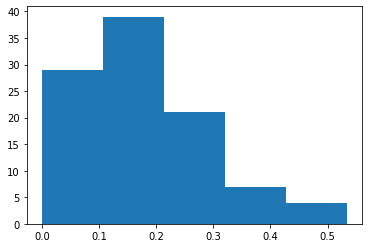

In [26]:
BINs = plt.hist(list(C.values()), bins = 5)

In [27]:
BINs

(array([29., 39., 21.,  7.,  4.]),
 array([0.        , 0.10666667, 0.21333333, 0.32      , 0.42666667,
        0.53333333]),
 <a list of 5 Patch objects>)

In [5]:
def aug_normalized_adjacency(adj):
    adj = adj + sp.eye(adj.shape[0])
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt).tocoo()

def row_normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [22]:
A = nx.adjacency_matrix(G)
A = aug_normalized_adjacency(A)

In [11]:
features = np.eye(A.shape[0])
features = row_normalize(features)

In [14]:
from scipy.sparse import csr_matrix, isspmatrix
isspmatrix(A)

True

In [15]:
labels = np.zeros(A.shape[0], )

In [16]:
tmp = np.array(list(C.values()))
label_count = 5
for i in range(label_count):
    thr_down = np.percentile(tmp, i*(100/label_count))
    thr_up = np.percentile(tmp,(i+1)*(100/label_count))
    labels[np.where((tmp <= thr_up) & (tmp > thr_down))] = i

In [17]:
data_graph = [A, features, labels]

In [18]:
np.savez('fake_graph.npz', A, features, labels)

In [21]:
isspmatrix(np.load('fake_graph.npz', allow_pickle = True)['arr_0'])

False

In [97]:
np.unique(labels)

array([0., 1., 2., 3., 4.])

In [32]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

def row_normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def generate_graph(n):
    '''
    input: 
        - n: number of graphs
    output:
        - G_set: a list of nx graphs [G_1, G_2, ..., G_n]
        - F_set: features associated with each node in the graph [F_1, ..., F_n] where L_i is a dictionary {node_1: features_1, ....}
        - L_set: labels associated with each node in the graph [L_1, ..., L_n] where L_i is a dictionary {node_1: label_1, ....}
    '''    
    G_set = []
    F_set = []
    L_set = []
    
    for i in range(n):
        G = nx.barabasi_albert_graph(100, 5)
        A = nx.adjacency_matrix(G)
        C = nx.clustering(G)
        labels = np.zeros(A.shape[0], )
        tmp = np.array(list(C.values()))
        label_count = 5
        for i in range(label_count):
            thr_down = np.percentile(tmp, i*(100/label_count))
            thr_up = np.percentile(tmp,(i+1)*(100/label_count))
            labels[np.where((tmp <= thr_up) & (tmp > thr_down))] = i
            
        features = np.eye(A.shape[0])
        features = row_normalize(features)
        G_set.append(G)
        F_set.append(features)
        L_set.append(labels)
    return G_set, F_set, L_set

In [26]:
def graph_to_subgraphs(G, features, labels, h, idx, info, total_subgraph):
    '''
    input:
        - G: a graph
        - features: node features
        - labels: node labels
        - h: h hops
        - idx: graph index
    output:
        - S_list: a list of DGL subgraphs where each subgraph is centered on a node i. {node i: adj_i, ....}
    '''
    S_list = []
    
    for i in list(G.nodes):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        features_temp = features[h_hops_neighbor]
        labels_temp = labels[h_hops_neighbor]
        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        S.ndata['x'] = features_temp
        S.ndata['y'] = labels_temp
        S.ndata['center_node'] = np.ones(features_temp.shape) * i
        S.ndata['graph_idx'] = np.ones(features_temp.shape) * idx
        S_list.append(S)
        
        info[str(idx) + '_' + str(i)] = labels[i]
        total_subgraph[str(idx) + '_' + str(i)] = S
        
    return S_list    
        

In [28]:
total_s_list, total_s, info = generate_dataset(10, 1)

In [36]:
import pandas as pd
import pickle
with open('list_subgraph.pkl', 'wb') as f:
    pickle.dump(total_s, f)
    
with open('label.pkl', 'wb') as f:
    pickle.dump(info, f)

df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
df.to_csv('fake_data.csv')

In [49]:
df.iloc[0]['name']

'0_0'

In [42]:
for i in range(1, 6):
    path = './fake_data/fold'+str(i)
    test_id = df.sample(frac = 0.2, replace = False, random_state = i)
    test_id.reset_index(drop = True).to_csv(path + '/test.csv')

    train_val_id = df[~df.index.isin(test_id.index)]
    val_id = train_val_id.sample(frac = 1/8, replace = False, random_state = i)
    train_id = train_val_id[~train_val_id.index.isin(val_id.index)]

    train_id.reset_index(drop = True).to_csv(path + '/train.csv')
    val_id.reset_index(drop = True).to_csv(path + '/val.csv')
    with open(path + '/list_subgraph.pkl', 'wb') as f:
        pickle.dump(total_s, f)
    
    with open(path + '/label.pkl', 'wb') as f:
        pickle.dump(info, f)

In [1]:
import os
os.chdir('../graphwave/')

In [3]:
%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import graphwave
from graphwave.shapes import build_graph
#from graphwave.shapes import cycle
#from graphwave.graphwave import *


In [27]:
width_basis = 100
nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 30  ## numbers of shapes to add 
#shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape=["star",6]
list_shapes = [["house"]] * n_shapes + [["fan"]] * n_shapes + [["star"]] * n_shapes

### 3. Give a name to the graph
identifier = 'AA'  ## just a name to distinguish between different trials
name_graph = 'houses'+ identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
add_edges = 100
G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=False,
                                       savefig=False)

2 211
238 156
95 9
216 88
236 70
51 308
32 250
309 172
67 222
51 167
172 34
123 10
260 10
40 10
282 243
71 66
307 273
173 288
181 103
278 308
9 235
63 2
120 265
1 243
39 145
92 248
220 247
305 134
153 124
259 88
37 25
109 227
296 284
133 256
308 176
192 217
69 13
109 206
80 141
286 124
295 76
125 44
294 139
84 308
253 155
201 169
163 80
82 305
232 10
99 84
49 278
209 229
175 26
45 13
237 192
166 133
173 309
275 85
303 161
122 116
144 135
194 134
124 152
225 100
88 124
47 260
139 159
286 135
178 104
240 9
243 159
138 15
0 152
94 232
138 290
99 133
69 198
134 89
115 225
123 4
107 183
28 44
157 14
58 74
176 143
131 162
2 130
138 302
241 92
261 279
187 108
299 181
172 88
18 22
20 298
66 94
93 67
143 267
244 94
107 216


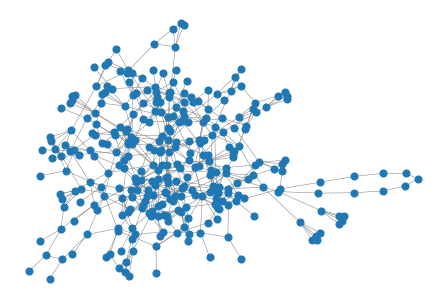

In [19]:
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

In [20]:
np.unique(role_id, return_counts = True)

(array([-205041,   -2031,     -21,       0,       2,       3,       4,
            202,   20503, 2070904]),
 array([30, 30, 30, 10, 30, 60, 30, 30, 30, 30]))

In [130]:
import os
os.chdir('../graphwave/')

import dgl
import matplotlib.pyplot as plt
import scipy.sparse as sp

%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle

import graphwave
from graphwave.shapes import build_graph
def row_normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def generate_graph_synthetic(n):
    '''
    input: 
        - n: number of graphs
    output:
        - G_set: a list of nx graphs [G_1, G_2, ..., G_n]
        - F_set: features associated with each node in the graph [F_1, ..., F_n] where L_i is a dictionary {node_1: features_1, ....}
        - L_set: labels associated with each node in the graph [L_1, ..., L_n] where L_i is a dictionary {node_1: label_1, ....}
    '''    
    G_set = []
    F_set = []
    L_set = []    
    
    for i in range(n):
        
        width_basis = 200

        ### 1. Choose the basis (cycle, torus or chain)
        basis_type = np.random.choice(["cycle"])

        ### 2. Add the shapes 
        n_shapes = 15  
        list_shapes = [["house"]] * n_shapes + [["fan"]] * n_shapes + [["star"]] * n_shapes + [["hollow"]] * n_shapes + [["diamond"]] * n_shapes

        ### 3. Pass all these parameters to the Graph Structure
        add_edges = 0 # random edges to add
        G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                               add_random_edges=add_edges, plot=False,
                                               savefig=False)
        
        A = nx.adjacency_matrix(G)        
        d = dict(zip(np.unique(role_id), range(len(np.unique(role_id)))))
        labels = [d[i] for i in role_id]
        
        features = np.eye(A.shape[0])
        features = row_normalize(features)
        G_set.append(G)
        F_set.append(features)
        L_set.append(labels)
    return G_set, F_set, L_set

def graph_to_subgraphs(G, features, labels, h, idx, info, total_subgraph, center_nodes):
    '''
    input:
        - G: a graph
        - features: node features
        - labels: node labels
        - h: h hops
        - idx: graph index
    output:
        - S_list: a list of DGL subgraphs where each subgraph is centered on a node i. {node i: adj_i, ....}
    '''
    S_list = []
    
    for i in list(G.nodes):
        h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
        #features_temp = features[h_hops_neighbor]
        #labels_temp = labels[h_hops_neighbor]
        S = dgl.DGLGraph()
        S.from_networkx(G.subgraph(h_hops_neighbor))
        #S.ndata['h'] = features_temp
        #S.ndata['y'] = labels_temp
        #S.ndata['center_node'] = np.ones(features_temp.shape) * np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]
        #S.ndata['graph_idx'] = np.ones(features_temp.shape) * idx
        S_list.append(S)
        
        info[str(idx) + '_' + str(i)] = labels[i]
        total_subgraph[str(idx) + '_' + str(i)] = S
        center_nodes[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]
        
    return S_list    
        

In [131]:
def generate_dataset_synthetic(n, h):
    '''
    generate h hops subgraphs for n 
    
    input: gfv
        - n: generate in total n graphs
        - h: h hops subgraph
    '''
    
    total_subgraph = {}
    info = {}
    center_nodes = {}
    
    G_set, F_set, L_set = generate_graph_synthetic(n)
    for i in range(len(G_set)):
        G = G_set[i]
        F = F_set[i]
        L = L_set[i]
        
        S_list = graph_to_subgraphs(G, F, L, h, i, info, total_subgraph, center_nodes)
        
    return total_subgraph, info, center_nodes

In [132]:
total_s, info, center_nodes = generate_dataset_synthetic(2, 2)

In [133]:
np.unique(list(info.values()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [158]:
labels = np.unique(list(info.values()))
test_labels = np.random.choice(labels, 4)
labels_left = [i for i in labels if i not in test_labels]
val_labels = np.random.choice(labels_left, 3)
train_labels = [i for i in labels_left if i not in val_labels]

In [159]:
train_labels

[0, 2, 3, 4, 5, 6, 11, 12, 13, 14]

In [134]:
import pickle
import pandas as pd
data_folder = '/n/scratch2/kexinhuang/MGNN_Data/synthetic/'
data_folder = '../data/'

df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
df.to_csv(data_folder + 'fake_data.csv')

for i in range(1, 2):
    
    labels = np.unique(list(info.values()))
    test_labels = np.random.choice(labels, 4)
    labels_left = [i for i in labels if i not in test_labels]
    val_labels = np.random.choice(labels_left, 3)
    train_labels = [i for i in labels_left if i not in val_labels]
    
    path = data_folder + '/fold'+str(i)
    #test_id = df.sample(frac = 0.2, replace = False, random_state = i)
    df[df.label.isin(train_labels)].reset_index(drop = True).to_csv(path + '/train.csv')
    df[df.label.isin(val_labels)].reset_index(drop = True).to_csv(path + '/val.csv')
    df[df.label.isin(test_labels)].reset_index(drop = True).to_csv(path + '/test.csv')

    #train_val_id = df[~df.index.isin(test_id.index)]
    #val_id = train_val_id.sample(frac = 1/8, replace = False, random_state = i)
    #train_id = train_val_id[~train_val_id.index.isin(val_id.index)]

    #train_id.reset_index(drop = True).to_csv(path + '/train.csv')
    #val_id.reset_index(drop = True).to_csv(path + '/val.csv')
    
    with open(path + '/list_subgraph.pkl', 'wb') as f:
        pickle.dump(total_s, f)
    
    with open(path + '/label.pkl', 'wb') as f:
        pickle.dump(info, f)
        
    with open(path + '/center.pkl', 'wb') as f:
        pickle.dump(center_nodes, f)

In [111]:
os.chdir('../data')
for i in range(1, 6):
    path = './fake_data/fold'+str(i)
    test_id = df.sample(frac = 0.2, replace = False, random_state = i)
    test_id.reset_index(drop = True).to_csv(path + '/test_graphwave.csv')

    train_val_id = df[~df.index.isin(test_id.index)]
    val_id = train_val_id.sample(frac = 1/8, replace = False, random_state = i)
    train_id = train_val_id[~train_val_id.index.isin(val_id.index)]

    train_id.reset_index(drop = True).to_csv(path + '/train_graphwave.csv')
    val_id.reset_index(drop = True).to_csv(path + '/val_graphwave.csv')
    with open(path + '/list_subgraph_graphwave.pkl', 'wb') as f:
        pickle.dump(total_s, f)
    
    with open(path + '/label_graphwave.pkl', 'wb') as f:
        pickle.dump(info, f)

In [32]:
len(total_s_list[1])

17

In [33]:
total_s_list[300].ndata['y']

tensor([7, 4, 5, 5, 6, 2, 3, 3, 2, 2])

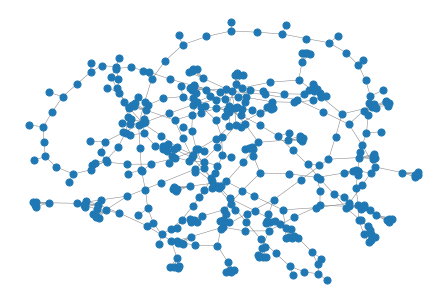

In [17]:
width_basis = 200

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
n_shapes = 30  
list_shapes = [["house"]] * n_shapes + [["fan"]] * n_shapes + [["star"]] * n_shapes

### 3. Pass all these parameters to the Graph Structure
add_edges = 0 # random edges to add
G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                       add_random_edges=add_edges, plot=False,
                                       savefig=False)
        
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

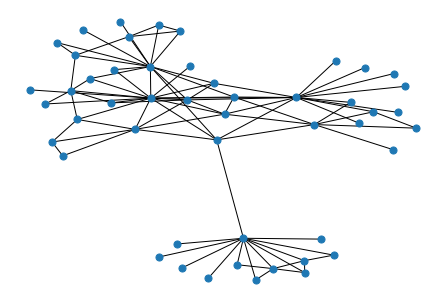

In [92]:
h_hops_neighbor = list(nx.single_source_shortest_path_length(g, i, cutoff=2).keys())
nx.draw(G.subgraph(h_hops_neighbor), node_size=50)
i+=1

In [101]:
i - 1

115

In [29]:
np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]

27

In [103]:
S.from_networkx(G.subgraph(h_hops_neighbor))

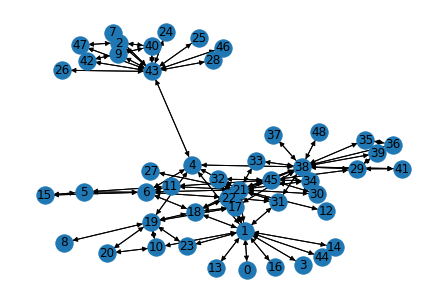

In [104]:
nx.draw(S.to_networkx(), with_labels = True)

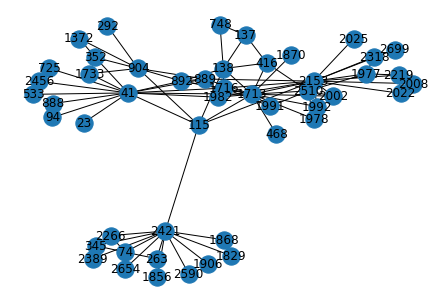

In [105]:
nx.draw(G.subgraph(h_hops_neighbor), with_labels = True)

In [9]:
h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
print(h_hops_neighbor)
features_temp = features[h_hops_neighbor]
labels_temp = labels[h_hops_neighbor]
S = dgl.DGLGraph()
S.from_networkx(G.subgraph(h_hops_neighbor))
S.ndata['h'] = features_temp
S.ndata['y'] = labels_temp

[2707, 774, 1389, 2344, 331, 1493, 821, 1050, 1079, 101, 179, 611, 867, 1732, 607, 1421, 1171, 1306, 1492, 1499, 1591, 864, 975, 1009, 1103, 1315, 1718, 1724]


In [83]:
aux_percentage = 0.4
mask = np.sort(np.random.choice(len(G.nodes), int(aux_percentage * len(G.nodes))))
aux_mask = np.array([False] * len(G.nodes))
aux_mask[mask] = True

In [84]:
mask_ = [aux_mask[i] for i in h_hops_neighbor]
aux_nodes = np.array(h_hops_neighbor)[mask_]
labels_aux = labels[aux_nodes]
map_nx_dgl = dict(zip(sorted(h_hops_neighbor), list(range(len(h_hops_neighbor)))))
labels_aux = labels_aux[np.argsort([map_nx_dgl[i] for i in aux_nodes])]
nodes_aux = np.sort([map_nx_dgl[i] for i in aux_nodes])

In [85]:
labels_aux

tensor([2, 2, 2, 2, 2, 6, 2, 2, 1, 2, 2])

In [86]:
aux_nodes

array([ 774, 1389, 2344,  331, 1493, 1050,  607,  975, 1009, 1103, 1315])

In [87]:
np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]

27

In [93]:
np.sort([map_nx_dgl[i] for i in aux_nodes])

array([ 2,  3,  5,  9, 10, 11, 13, 16, 17, 20, 26])

In [89]:
sorted(aux_nodes)

[331, 607, 774, 975, 1009, 1050, 1103, 1315, 1389, 1493, 2344]

In [90]:
labels_aux[np.argsort([map_nx_dgl[i] for i in aux_nodes])]

tensor([2, 2, 2, 2, 1, 6, 2, 2, 2, 2, 2])

In [91]:
labels_temp

tensor([2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 1,
        2, 2, 2, 2])

In [25]:
labels_temp[np.argsort(h_hops_neighbor)]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 6, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 2, 2,
        2, 2, 2, 2])

In [22]:
# map between an nx graph and an DGL graph
map_nx_dgl = dict(zip(sorted(h_hops_neighbor), list(range(len(h_hops_neighbor)))))
[map_nx_dgl[i] for i in h_hops_neighbor]

[27,
 5,
 17,
 26,
 2,
 20,
 6,
 11,
 12,
 0,
 1,
 4,
 8,
 25,
 3,
 18,
 14,
 15,
 19,
 21,
 22,
 7,
 9,
 10,
 13,
 16,
 23,
 24]

In [10]:
labels_temp

tensor([2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 1,
        2, 2, 2, 2])

In [11]:
S.ndata['y']

tensor([2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 1,
        2, 2, 2, 2])

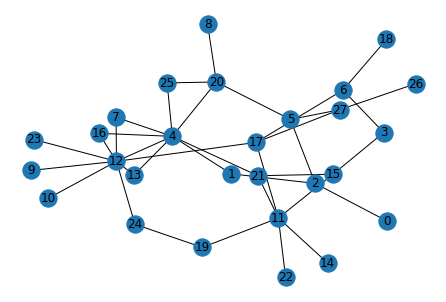

In [23]:
nx.draw(S.to_networkx().to_undirected(), with_labels = True)

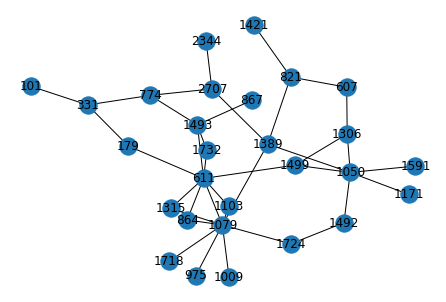

In [13]:
nx.draw(G.subgraph(h_hops_neighbor), with_labels = True)

In [40]:
# connected caveman 
import networkx as nx
import torch
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import dgl
import numpy as np
from tqdm import tqdm

l = 10
k = 30
p = 0.01
G = nx.relaxed_caveman_graph(l, k, p, seed=42)

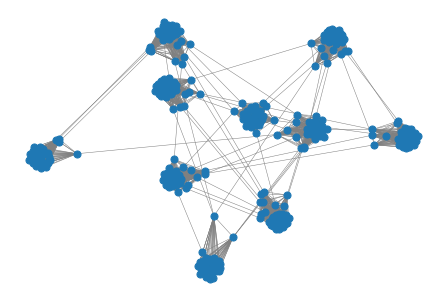

In [41]:
nx.draw(G, node_size=50, edge_color="gray", width=0.5)

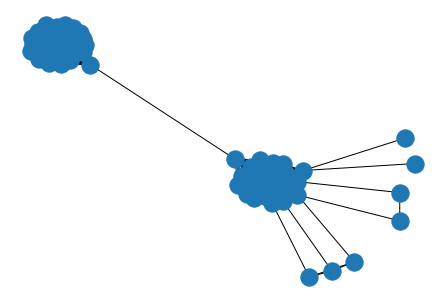

In [42]:
h_hops_neighbor = list(nx.single_source_shortest_path_length(G, 4, cutoff=2).keys())
nx.draw(G.subgraph(h_hops_neighbor))

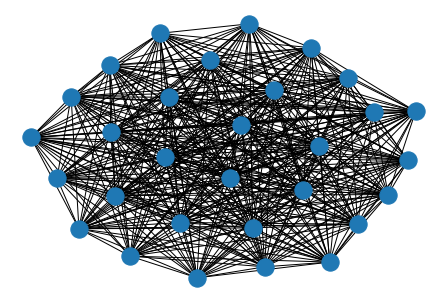

In [43]:
nx.draw(G.subgraph(list(range(k))))

In [44]:
labels = list(range(l))
labels = [[i] * k for i in labels]
labels = np.array(labels).flatten()

In [45]:
# inject features as labels
features = np.zeros((labels.shape[0], l))
for i in range(l):
    features[i*k : i*k+k, i] = 1

In [46]:
# high resource setting

# create auxillary nodes available to us during training
aux_percentage = 0.4
mask = np.sort(np.random.choice(len(G.nodes), int(aux_percentage * len(G.nodes)), replace=False))
aux_mask = np.array([False] * len(G.nodes))
aux_mask[mask] = True

h = 2
idx = 0
info = {}
total_subgraph = {} 
center_node = {}
labels_aux = {}
nodes_aux = {}

for i in tqdm(list(G.nodes)):
    h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
    #print(h_hops_neighbor)
    features_temp = features[h_hops_neighbor]
    features_temp = features_temp[np.argsort(h_hops_neighbor)]
    labels_temp = labels[h_hops_neighbor]
    labels_temp = labels_temp[np.argsort(h_hops_neighbor)]
    
    S = dgl.DGLGraph()
    S.from_networkx(G.subgraph(h_hops_neighbor))
    S.ndata['h'] = features_temp
    S.ndata['y'] = labels_temp
    
    mask_ = [aux_mask[i] for i in h_hops_neighbor]
    aux_nodes = np.array(h_hops_neighbor)[mask_]
    l_aux = labels[aux_nodes]
    map_nx_dgl = dict(zip(sorted(h_hops_neighbor), list(range(len(h_hops_neighbor)))))
    l_aux = l_aux[np.argsort([map_nx_dgl[i] for i in aux_nodes])]
    n_aux = np.sort([map_nx_dgl[i] for i in aux_nodes])

    info[str(idx) + '_' + str(i)] = labels[i]
    total_subgraph[str(idx) + '_' + str(i)] = S
    center_node[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]            
    labels_aux[str(idx) + '_' + str(i)] = l_aux
    nodes_aux[str(idx) + '_' + str(i)] = n_aux
    

100%|██████████| 300/300 [00:02<00:00, 122.62it/s]


In [50]:
import pickle
import pandas as pd
data_folder = '/n/scratch2/kexinhuang/MGNN_Data/cora/'
data_folder = '../../MGNN_Local_Data/caveman/'

df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
#df.to_csv(data_folder + 'fake_data_cora.csv')

data_list = list(range(len(G.nodes)))
train_id = mask
val_test = list(set(data_list) - set(train_id))
val_id = np.random.choice(val_test, int(0.5 * len(val_test)), replace=False)
test_id = list(set(val_test) - set(val_id))

path = data_folder
df.iloc[test_id].reset_index(drop = True).to_csv(path + '/test.csv')
df.iloc[train_id].reset_index(drop = True).to_csv(path + '/train.csv')
df.iloc[val_id].reset_index(drop = True).to_csv(path + '/val.csv')

with open(path + '/list_subgraph.pkl', 'wb') as f:
    pickle.dump(total_subgraph, f)

with open(path + '/label.pkl', 'wb') as f:
    pickle.dump(info, f)

with open(path + '/center.pkl', 'wb') as f:
    pickle.dump(center_node, f)

with open(path + '/labels_aux.pkl', 'wb') as f:
    pickle.dump(labels_aux, f)

with open(path + '/nodes_aux.pkl', 'wb') as f:
    pickle.dump(nodes_aux, f)

In [ ]:
# cora

In [52]:
from dgl.data import citation_graph as citegrh
import networkx as nx
import torch as th
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import dgl

def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    train_mask = th.BoolTensor(data.train_mask)
    test_mask = th.BoolTensor(data.test_mask)
    g = data.graph
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, train_mask, test_mask

g, features, labels, train_mask, test_mask = load_cora_data()

In [53]:
data = citegrh.load_cora()
g = data.graph
g = g.to_undirected()

In [3]:
from tqdm import tqdm
import numpy as np

In [116]:
# high resource setting
G = g

# create auxillary nodes available to us during training
aux_percentage = 0.4
mask = np.sort(np.random.choice(len(G.nodes), int(aux_percentage * len(G.nodes)), replace=False))
aux_mask = np.array([False] * len(G.nodes))
aux_mask[mask] = True

h = 2
idx = 0
info = {}
total_subgraph = {} 
center_node = {}
labels_aux = {}
nodes_aux = {}

for i in tqdm(list(G.nodes)):
    h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
    #print(h_hops_neighbor)
    features_temp = features[h_hops_neighbor]
    features_temp = features_temp[np.argsort(h_hops_neighbor)]
    labels_temp = labels[h_hops_neighbor]
    labels_temp = labels_temp[np.argsort(h_hops_neighbor)]
    
    S = dgl.DGLGraph()
    S.from_networkx(G.subgraph(h_hops_neighbor))
    S.ndata['h'] = features_temp
    S.ndata['y'] = labels_temp
    
    mask_ = [aux_mask[i] for i in h_hops_neighbor]
    aux_nodes = np.array(h_hops_neighbor)[mask_]
    l_aux = labels[aux_nodes]
    map_nx_dgl = dict(zip(sorted(h_hops_neighbor), list(range(len(h_hops_neighbor)))))
    l_aux = l_aux[np.argsort([map_nx_dgl[i] for i in aux_nodes])]
    n_aux = np.sort([map_nx_dgl[i] for i in aux_nodes])

    info[str(idx) + '_' + str(i)] = labels[i]
    total_subgraph[str(idx) + '_' + str(i)] = S
    center_node[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]            
    labels_aux[str(idx) + '_' + str(i)] = l_aux
    nodes_aux[str(idx) + '_' + str(i)] = n_aux
    

100%|██████████| 2708/2708 [00:09<00:00, 290.97it/s]


In [128]:
import pickle
import pandas as pd
data_folder = '/n/scratch2/kexinhuang/MGNN_Data/cora/'
data_folder = '../../MGNN_Local_Data/cora/'

df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
#df.to_csv(data_folder + 'fake_data_cora.csv')

data_list = list(range(len(G.nodes)))
train_id = mask
val_test = list(set(data_list) - set(train_id))
val_id = np.random.choice(val_test, int(0.5 * len(val_test)), replace=False)
test_id = list(set(val_test) - set(val_id))

path = data_folder
df.iloc[test_id].reset_index(drop = True).to_csv(path + '/test.csv')
df.iloc[train_id].reset_index(drop = True).to_csv(path + '/train.csv')
df.iloc[val_id].reset_index(drop = True).to_csv(path + '/val.csv')

with open(path + '/list_subgraph.pkl', 'wb') as f:
    pickle.dump(total_subgraph, f)

with open(path + '/label.pkl', 'wb') as f:
    pickle.dump(info, f)

with open(path + '/center.pkl', 'wb') as f:
    pickle.dump(center_node, f)

with open(path + '/labels_aux.pkl', 'wb') as f:
    pickle.dump(labels_aux, f)

with open(path + '/nodes_aux.pkl', 'wb') as f:
    pickle.dump(nodes_aux, f)

In [56]:
from tqdm import tqdm

In [57]:
# low resource setting
G = g
h = 2
idx = 0
info = {}
total_subgraph = {} 
center_node = {}

for i in tqdm(list(G.nodes)):
    h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
    #print(h_hops_neighbor)
    features_temp = features[h_hops_neighbor]
    features_temp = features_temp[np.argsort(h_hops_neighbor)]
    labels_temp = labels[h_hops_neighbor]
    labels_temp = labels_temp[np.argsort(h_hops_neighbor)]
    
    S = dgl.DGLGraph()
    S.from_networkx(G.subgraph(h_hops_neighbor))
    S.ndata['h'] = features_temp
    S.ndata['y'] = labels_temp
    
    info[str(idx) + '_' + str(i)] = labels[i]
    total_subgraph[str(idx) + '_' + str(i)] = S
    center_node[str(idx) + '_' + str(i)] = np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]                


100%|██████████| 2708/2708 [00:09<00:00, 294.46it/s]


In [66]:
G = g
h = 3

In [67]:
i

110

In [68]:
h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
S = dgl.DGLGraph()
S.from_networkx(G.subgraph(h_hops_neighbor))
i+=1

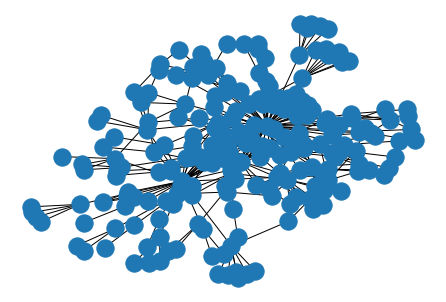

In [69]:
nx.draw(G.subgraph(h_hops_neighbor))

In [121]:
data_folder = '/n/scratch2/kexinhuang/MGNN_Data/cora/'

In [58]:
import pickle
import pandas as pd
data_folder = '/n/scratch2/kexinhuang/MGNN_Data/cora/'
data_folder = '../../MGNN_Local_Data/cora2/'

df = pd.DataFrame.from_dict(info, orient='index').reset_index().rename(columns={"index": "name", 0: "label"})
df.to_csv(data_folder + 'fake_data_cora.csv')

In [60]:

for i in range(1, 2):
    path = data_folder
    test_id = df.sample(frac = 0.2, replace = False, random_state = i)
    test_id.reset_index(drop = True).to_csv(path + '/test.csv')

    train_val_id = df[~df.index.isin(test_id.index)]
    val_id = train_val_id.sample(frac = 1/8, replace = False, random_state = i)
    train_id = train_val_id[~train_val_id.index.isin(val_id.index)]

    train_id.reset_index(drop = True).to_csv(path + '/train.csv')
    val_id.reset_index(drop = True).to_csv(path + '/val.csv')
    with open(path + '/list_subgraph.pkl', 'wb') as f:
        pickle.dump(total_subgraph, f)
    
    with open(path + '/label.pkl', 'wb') as f:
        pickle.dump(info, f)
        
    with open(path + '/center.pkl', 'wb') as f:
        pickle.dump(center_node, f)

In [209]:
len(total_subgraph)

2708

In [211]:
len(G.edges())

5278

In [154]:
import time

In [157]:
time.time()
list(nx.ego_graph(G, 1, radius = 2, undirected=True).nodes())
print(time.clock())

726.981374


/Users/kexinhuang/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
time.time()
list(nx.single_source_shortest_path_length(G, 1, cutoff=h).keys())
print(time.clock())

726.989503


/Users/kexinhuang/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
G.subgraph

In [77]:
idx = 0
i = 10
h = 1
h_hops_neighbor = list(nx.single_source_shortest_path_length(G, i, cutoff=h).keys())
#features_temp = features[h_hops_neighbor]
#labels_temp = labels[h_hops_neighbor]
S = dgl.DGLGraph()
S.from_networkx(G.subgraph(h_hops_neighbor))
#S.ndata['x'] = features_temp
#S.ndata['y'] = labels_temp
S.ndata['center_node'] = np.ones(len(S)) * np.argwhere(np.argsort(h_hops_neighbor) == 0)[0][0]
S.ndata['graph_idx'] = np.ones(len(S)) * idx

In [88]:
S.nodes[0].data['center_node'].detach().numpy()[0]

10.0

In [147]:
import csv
dictLabels = {}
with open('data.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader, None)  # skip (filename, label)
    for i, row in enumerate(csvreader):
        filename = row[1]
        label = row[2]
        # append filename to current label
        if label in dictLabels.keys():
            dictLabels[label].append(filename)
        else:
            dictLabels[label] = [filename]

In [142]:
dictLabels

{'n01930112': ['n0193011200000001.jpg',
  'n0193011200000004.jpg',
  'n0193011200000005.jpg',
  'n0193011200000006.jpg',
  'n0193011200000008.jpg',
  'n0193011200000011.jpg',
  'n0193011200000012.jpg',
  'n0193011200000013.jpg',
  'n0193011200000014.jpg',
  'n0193011200000017.jpg',
  'n0193011200000020.jpg',
  'n0193011200000022.jpg',
  'n0193011200000023.jpg',
  'n0193011200000025.jpg',
  'n0193011200000028.jpg',
  'n0193011200000031.jpg',
  'n0193011200000032.jpg',
  'n0193011200000038.jpg',
  'n0193011200000039.jpg',
  'n0193011200000040.jpg',
  'n0193011200000041.jpg',
  'n0193011200000042.jpg',
  'n0193011200000044.jpg',
  'n0193011200000047.jpg',
  'n0193011200000048.jpg',
  'n0193011200000049.jpg',
  'n0193011200000050.jpg',
  'n0193011200000052.jpg',
  'n0193011200000053.jpg',
  'n0193011200000056.jpg',
  'n0193011200000057.jpg',
  'n0193011200000058.jpg',
  'n0193011200000059.jpg',
  'n0193011200000062.jpg',
  'n0193011200000063.jpg',
  'n0193011200000067.jpg',
  'n01930112000

In [149]:
dictLabels

{'2.0': ['0_0',
  '0_1',
  '0_3',
  '0_6',
  '0_8',
  '0_13',
  '0_14',
  '0_19',
  '0_30',
  '0_33',
  '0_47',
  '0_50',
  '0_54',
  '0_62',
  '0_84',
  '1_0',
  '1_1',
  '1_3',
  '1_6',
  '1_8',
  '1_13',
  '1_14',
  '1_19',
  '1_30',
  '1_33',
  '1_47',
  '1_50',
  '1_54',
  '1_62',
  '1_84',
  '2_0',
  '2_1',
  '2_3',
  '2_6',
  '2_8',
  '2_13',
  '2_14',
  '2_19',
  '2_30',
  '2_33',
  '2_47',
  '2_50',
  '2_54',
  '2_62',
  '2_84',
  '3_0',
  '3_1',
  '3_3',
  '3_6',
  '3_8',
  '3_13',
  '3_14',
  '3_19',
  '3_30',
  '3_33',
  '3_47',
  '3_50',
  '3_54',
  '3_62',
  '3_84',
  '4_0',
  '4_1',
  '4_3',
  '4_6',
  '4_8',
  '4_13',
  '4_14',
  '4_19',
  '4_30',
  '4_33',
  '4_47',
  '4_50',
  '4_54',
  '4_62',
  '4_84',
  '5_0',
  '5_1',
  '5_3',
  '5_6',
  '5_8',
  '5_13',
  '5_14',
  '5_19',
  '5_30',
  '5_33',
  '5_47',
  '5_50',
  '5_54',
  '5_62',
  '5_84',
  '6_0',
  '6_1',
  '6_3',
  '6_6',
  '6_8',
  '6_13',
  '6_14',
  '6_19',
  '6_30',
  '6_33',
  '6_47',
  '6_50',
  '6_54'

In [151]:
import os
os.chdir('../src')

In [152]:
from MiniImagenet import MiniImagenet
mini_test = MiniImagenet('/Users/kexinhuang/Downloads/miniimagenet', mode='test', n_way=5, k_shot=1,
                         k_query=15,
                         batchsz=100, resize=84)

shuffle DB :test, b:100, 5-way, 1-shot, 15-query, resize:84


In [153]:
mini_test

In [154]:
from torch.utils.data import DataLoader
db = DataLoader(mini_test, 4, shuffle=True, num_workers=1, pin_memory=True)

In [155]:
for step, (x_spt, y_spt, x_qry, y_qry) in enumerate(db):
    
    break

In [156]:
x_spt.shape

torch.Size([4, 5, 3, 84, 84])

In [157]:
y_spt.shape

torch.Size([4, 5])

In [159]:
x_qry.shape

torch.Size([4, 75, 3, 84, 84])

In [1]:
import torch

In [1]:
l = [[('0_71', '4_6', '8_28', '6_61')], [('7_56', '0_80', '6_70', '7_83')], [('8_14', '2_53', '5_22', '5_34')], [('5_20', '0_32', '6_47', '5_33')], [('5_63', '5_40', '2_16', '9_96')]]

In [2]:
import numpy as np
support_x = np.array([item  # obtain a list of DGL subgraphs index
                             for sublist in l for item in sublist]).astype(str)
      

In [7]:
support_x.astype(np.str)

array([['0_71', '4_6', '8_28', '6_61'],
       ['7_56', '0_80', '6_70', '7_83'],
       ['8_14', '2_53', '5_22', '5_34'],
       ['5_20', '0_32', '6_47', '5_33'],
       ['5_63', '5_40', '2_16', '9_96']], dtype='<U4')

In [8]:
from dgl.data import MiniGCDataset
dataset = MiniGCDataset(80, 10, 20)

In [9]:
dataset

In [10]:
for i in dataset:
    print(i)

(DGLGraph(num_nodes=19, num_edges=57,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=18, num_edges=54,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=10, num_edges=30,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=16, num_edges=48,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=14, num_edges=42,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=15, num_edges=45,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=13, num_edges=39,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=18, num_edges=54,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=14, num_edges=42,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=16, num_edges=48,
         ndata_schemes={}
         edata_schemes={}), 0)
(DGLGraph(num_nodes=11, num_edges=31,
         nda